In [2]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def load_df(csv_path='train.csv', nrows=None) -> pd.DataFrame:
    """
        JSON 형태로 되어있는 컬럼들을 모아서 DataFrame형태로 바꾸는 함수
        converters : JSON 컬럼들의 값들을 json_loads로 데이터 프레임화 시키는 함수를 적용하는 파라미터
        dtype : 데이터를 불러올 때 fullVisitorId의  dtype을 미리 str로 정의
        nrows :  limit와 같은 존재 너무 크면 오래걸리니까 2만으로 줄임.
    """
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    '''
    normalize는 json을 정규화(평평하게)만드는 것이며 이는 중첩된 구조를 하나의 테이블로 펼쳐서, 각각의 요소를 행으로 나타내는 것
    흔히 우리가 아는 테이블의 형태로 나타나게 된다. 
    새로운 컬럼을 for문을 통해서 각 column마다 서브 column name으로 할당
    정규화 되기 전 컬럼은 삭제하고, 새로운 컬럼으로 덮어씌운다.
    '''
    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

df = load_df(nrows=200000)

## DROP

In [3]:
drop_columns = ['socialEngagementType', 'device_browser', 'device_browserVersion', 'device_browserSize', 'device_operatingSystem', 'device_operatingSystemVersion', 'device_mobileDeviceBranding', 'device_mobileDeviceModel', 'device_mobileInputSelector', 'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName', 'device_flashVersion', 'device_language', 'device_screenColors', 'device_screenResolution', 'geoNetwork_subContinent', 'geoNetwork_region', 'geoNetwork_metro', 'geoNetwork_city', 'geoNetwork_cityId', 'geoNetwork_networkDomain', 'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_networkLocation', 'trafficSource_adwordsClickInfo.criteriaParameters', 'trafficSource_referralPath', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adContent']
df =df.drop(drop_columns,axis=1)

## 전처리
### str 변환 함수

In [4]:
def transform_str (df:pd.DataFrame)-> pd.DataFrame:
    """
        str 형태로 변환하는 함수
    """
    transform_str_columns = ['fullVisitorId']
    df[transform_str_columns]=df[transform_str_columns].astype(str)
    return df

transform_str(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   channelGrouping                               200000 non-null  object
 1   date                                          200000 non-null  int64 
 2   fullVisitorId                                 200000 non-null  object
 3   sessionId                                     200000 non-null  object
 4   visitId                                       200000 non-null  int64 
 5   visitNumber                                   200000 non-null  int64 
 6   visitStartTime                                200000 non-null  int64 
 7   device_isMobile                               200000 non-null  bool  
 8   device_deviceCategory                         200000 non-null  object
 9   geoNetwork_continent                          200000 non-nu

### str->int 변환 함수
-  totals_visits은 1로만 차있는 데이터라서 변환이 필요 없음.

In [5]:
def change_numeric(df:pd.DataFrame)-> pd.DataFrame :
    '''
        결측치를 처리하고 문자열-> int형으로 형변환하는 함수
    '''
    transform_int_columns = ['totals_hits','totals_pageviews','totals_newVisits','totals_transactionRevenue']
    df[transform_int_columns]=df[transform_int_columns].fillna(0)
    df[transform_int_columns]= np.int64(df[transform_int_columns])
    return df 
    
df=change_numeric(df)
df.describe()


,date,visitId,visitNumber,visitStartTime,totals_hits,totals_pageviews,totals_newVisits,totals_transactionRevenue
count,2.000000e+05,2.000000e+05,200000.00000,2.000000e+05,200000.000000,200000.000000,200000.00000,2.000000e+05
mean,2.016529e+07,1.484264e+09,2.24101,1.484264e+09,4.503975,3.773320,0.78424,1.667208e+06
std,4.678858e+03,8.784533e+06,9.19020,8.784533e+06,9.502970,6.907599,0.41135,3.402496e+07
min,2.016080e+07,1.470380e+09,1.00000,1.470380e+09,1.000000,0.000000,0.00000,0.000000e+00
25%,2.016103e+07,1.477850e+09,1.00000,1.477850e+09,1.000000,1.000000,1.00000,0.000000e+00
50%,2.016121e+07,1.481299e+09,1.00000,1.481299e+09,2.000000,2.000000,1.00000,0.000000e+00
75%,2.017041e+07,1.491990e+09,1.00000,1.491990e+09,4.000000,3.000000,1.00000,0.000000e+00
max,2.017080e+07,1.501657e+09,389.00000,1.501657e+09,500.000000,400.000000,1.00000,5.498000e+09


### 날짜형 데이터로 변환

In [63]:
df['date'] =pd.to_datetime(df['date'], format='%Y%m%d')
df['visitStartTime']=pd.to_datetime(df['visitStartTime'],unit='s')

df['date_of_weekday']=df.visitStartTime.dt.dayofweek
df['date_of_weekday']= df.groupby(df['date_of_weekday'])['fullVisitorId'].nunique()
df['date_of_weekday']=df['date_of_weekday'].dropna()

df['hour_of_day'] = df['visitStartTime'].dt.hour

### Revenue

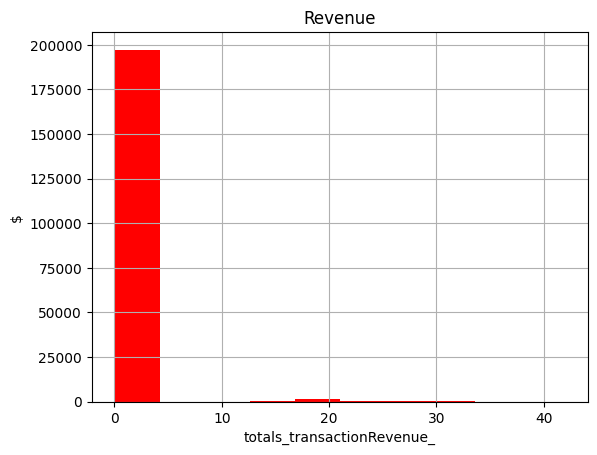

In [7]:
totals_transactionRevenue_median = df[df['totals_transactionRevenue'] != 0]['totals_transactionRevenue'].median()

df['totals_transactionRevenue'] = df['totals_transactionRevenue'].fillna(totals_transactionRevenue_median)

df['totals_transactionRevenue']=np.power(df['totals_transactionRevenue'],1/6).round(2)

df['totals_transactionRevenue'].hist(color='red')
plt.xlabel('totals_transactionRevenue_')
plt.ylabel('$')
plt.title('Revenue')
plt.show()

### ChannelGrouping

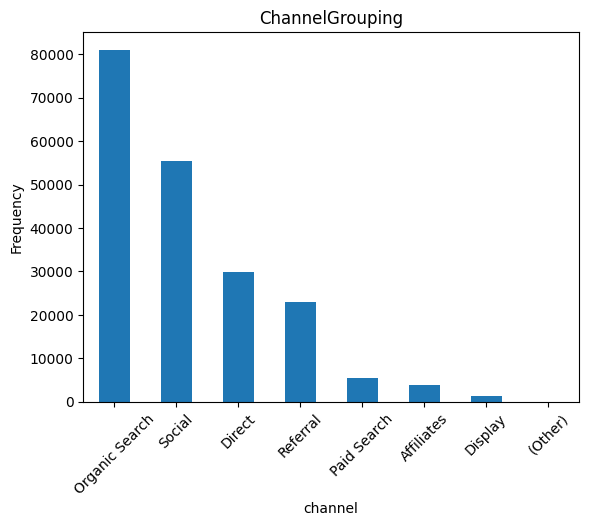

In [8]:
df.channelGrouping.value_counts().plot.bar()
plt.xlabel('channel')
plt.ylabel('Frequency')
plt.title('ChannelGrouping')
plt.xticks(rotation=45)
plt.show()

### GeoNetwork_continent

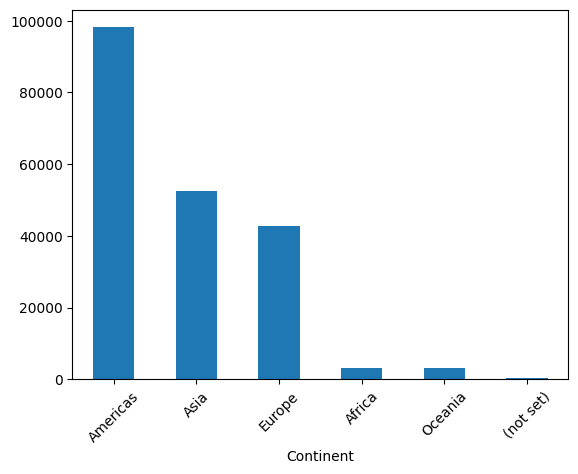

In [9]:
df.geoNetwork_continent.value_counts().plot.bar()
plt.xlabel('Continent')
plt.xticks(rotation=45)
plt.show()

In [10]:
# df['date_of_Month']=df.visitStartTime.dt.to_period('M')
# df_MAU=df.groupby(df['date_of_Month'])['fullVisitorId'].nunique()
# plt.figure(figsize=(12,6))
# df_MAU.plot(kind='line',legend='fullVisitorId')
# plt.xlabel('Month')
# plt.ylabel('User')
# plt.legend()
# plt.title('Month Active Users(MAU)')

### 첫 방문자와 재 방문자의 비율

In [11]:
first_session = df[df.visitNumber == 1]['visitNumber'].count()
returning_session_ratio  = df[df.visitNumber != 1]['visitNumber'].count()

session_count= df.visitNumber.count()

first_session_ratio = (first_session/session_count * 100)
print(f"첫 방문자의 비율: {first_session_ratio:.2f}%")

returning_session_ratio  = (returning_session_ratio /session_count * 100)
print(f"재방문자의 비율: {returning_session_ratio :.2f}%")

첫 방문자의 비율: 78.42%
재방문자의 비율: 21.58%


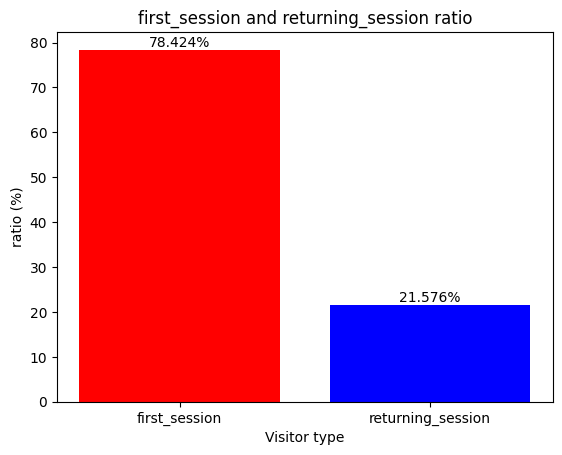

In [12]:
labels = ['first_session', 'returning_session']
ratios = [first_session_ratio, returning_session_ratio]

plt.bar(labels, ratios, color=['red', 'blue'])


plt.title('first_session and returning_session ratio')
plt.xlabel('Visitor type')
plt.ylabel('ratio (%)')
plt.text(0, ratios[0]+0.7, f'{ratios[0]}%', ha='center')
plt.text(1, ratios[1]+0.7, f'{ratios[1]}%', ha='center')

# 그래프 출력
plt.show()

In [13]:
df.iloc[:,10:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 18 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   geoNetwork_country                            200000 non-null  object 
 1   totals_visits                                 200000 non-null  object 
 2   totals_hits                                   200000 non-null  int64  
 3   totals_pageviews                              200000 non-null  int64  
 4   totals_bounces                                99280 non-null   object 
 5   totals_newVisits                              200000 non-null  int64  
 6   totals_transactionRevenue                     200000 non-null  float64
 7   trafficSource_campaign                        200000 non-null  object 
 8   trafficSource_source                          200000 non-null  object 
 9   trafficSource_medium                          20

## 채널별 효과 분석 (재혁)
    - 캠페인으로 들어온 사람은 다른 사람과 다른 특징을 가지고 있는지 분석
    - 매출이 우수한 채널이 있는지

### 시간대 별 차이

캠페인에 참여한 사람들은 11시에 접속수가 가장 적고, 3,15,18,20시가 가장 많은 접속이 이루어지는걸 볼 수 있음.

캠페인 참여 안한 사람들은 5시에 최저, 17,18시가 가장 많은 접속 했음을 알 수 있고,  캠페인에 참여하지 않은 사람들은 주로 오후에 활동하는것으로 판단된다.

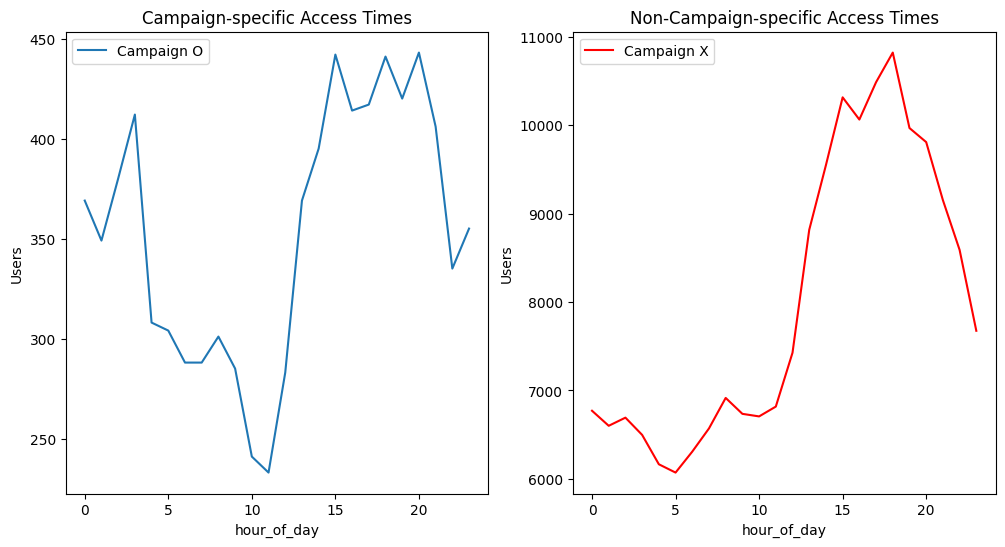

In [40]:
df_set=df.loc[df['trafficSource_campaign'] != '(not set)']
df_not_set=df.loc[df['trafficSource_campaign'] == '(not set)']

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
df_set.groupby('hour_of_day')['hour_of_day'].value_counts().plot(kind='line',label='Campaign O')
plt.title('Campaign-specific Access Times')
plt.ylabel('Users')
plt.legend()

plt.subplot(1,2,2)
df_not_set.groupby('hour_of_day')['hour_of_day'].value_counts().plot(kind='line',color='red',label='Campaign X')
plt.title('Non-Campaign-specific Access Times')
plt.ylabel('Users')
plt.legend()

### 요일별 차이 
- 캠페인에 참여한 사람들의 데이터는 안나오는 문제가 발생 = 모두다 NaN값

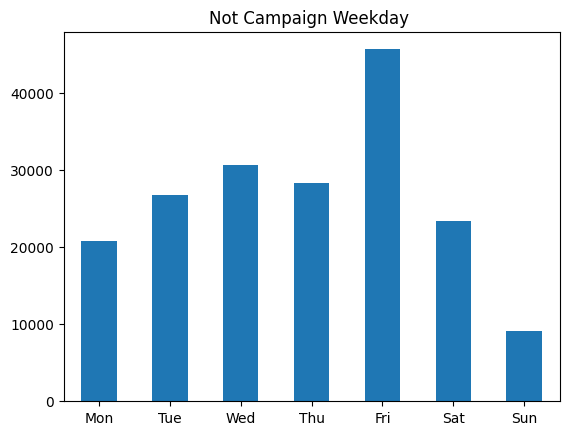

In [44]:
df_set=df.loc[df['trafficSource_campaign'] != '(not set)']
df_not_set=df.loc[df['trafficSource_campaign'] == '(not set)']

df_not_set['date_of_weekday'].dropna().plot(kind='bar')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation = 0)
plt.title('Not Campaign Weekday ')
plt.show()


### 캠페인 여부에 따른 채널 별 접수 차이

- 캠패인에 참여 안한 사람들은 40%는 Organic( 검색엔진에 키워드를 통해 웹사이트에 유입)

  - 27%의 사람들은 Social을 통한 유입, 14%는 Direct로 유입,  0.3%의 사람들이 Paid Search(유료 광고 )로 유입

-  캠페인에 참여한 사람들은 55% 사람들은Paid Search(유료 검색)으로 들어옴.
 
   - 44%의 사람들이 Affiliates(제휴 | 계열사) 로 들어옴.

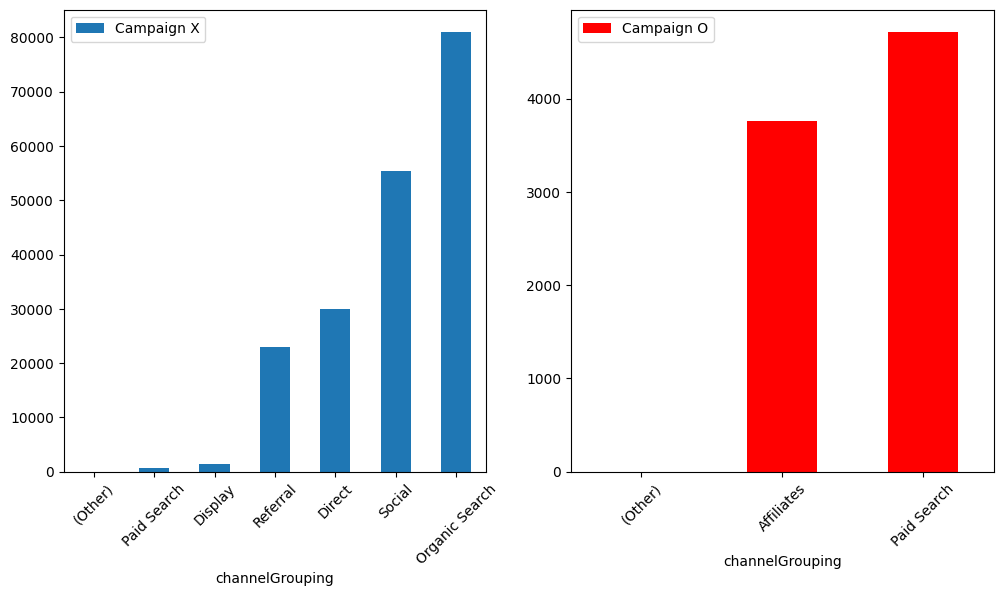

In [73]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
df_not_set['channelGrouping'].value_counts().sort_values().plot(kind='bar',label='Campaign X')
plt.xticks(rotation=45)
plt.legend()

plt.subplot(1,2,2)
df_set['channelGrouping'].value_counts().sort_values().plot(kind='bar',color='red',label='Campaign O')
plt.xticks(rotation=45)
plt.legend()

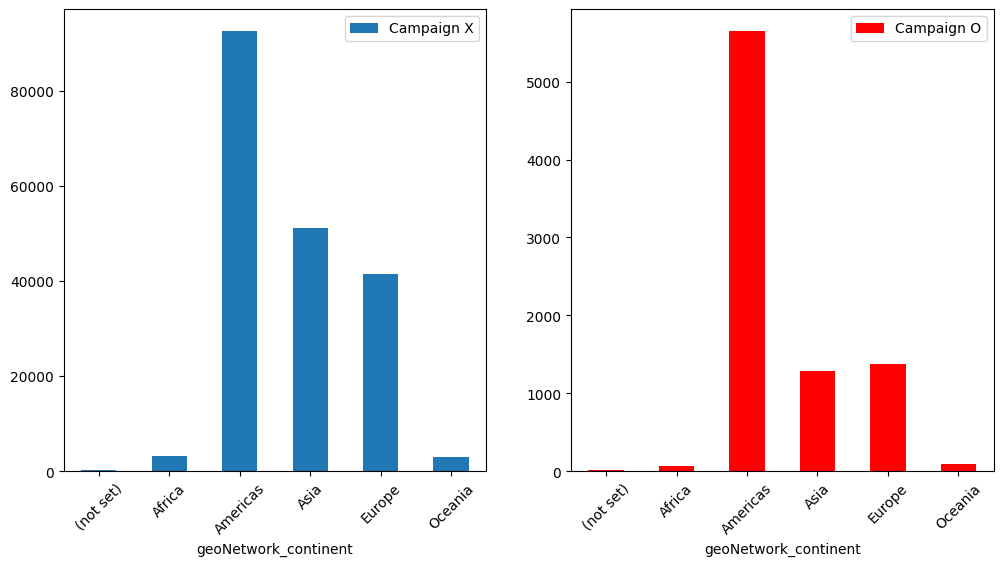

In [77]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
df_not_set['geoNetwork_continent'].value_counts().sort_index().plot(kind='bar',label='Campaign X')
plt.xticks(rotation=45)
plt.legend()

plt.subplot(1,2,2)
df_set['geoNetwork_continent'].value_counts().sort_index().plot(kind='bar',color='red',label='Campaign O')
plt.xticks(rotation=45)
plt.legend()